In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd



Mounted at /content/drive


In [2]:


base_folder = '/content/drive/MyDrive/SoundWaves'

audio_files = []
labels = []

# Walk through all subfolders and files
for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(('.mp3', '.wav', '.flac')):
            file_path = os.path.join(root, file)
            # label = name of the folder containing this file
            label = os.path.basename(root)

            audio_files.append(file_path)
            labels.append(label)

print(f"Total audio files found: {len(audio_files)}")
for i in range(15):
    print(audio_files[i], "→", labels[i])


Total audio files found: 15
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400P.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400N.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400L.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400I.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400H.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400E.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Dusky dolphin/6412400A.wav → Dusky dolphin
/content/drive/MyDrive/SoundWaves/Gray Whale/9900100A.wav → Gray Whale
/content/drive/MyDrive/SoundWaves/Gray Whale/99001009.wav → Gray Whale
/content/drive/MyDrive/SoundWaves/Gray Whale/99001008.wav → Gray Whale
/content/drive/MyDrive/SoundWaves/Gray Whale/99001006.wav → Gray Whale
/content/drive/MyDrive/SoundWaves/Gray Whale/9900200A.wav → Gray Whale
/content/drive/MyDrive/SoundWaves/Bottlenose/74008001.wav → Bottlenose
/conten

In [3]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import tqdm as tqdm

#Segmentation
output_folder='/content/drive/MyDrive/Spectogram'
sr = 22050
segment_duration = 4
overlap = 0.5
n_mels=128

#Function to segment audio into 4 secs
def segments(y,sr, segment_duration=4, overlap=0.5):
  segment_length = int(sr * segment_duration)
  hop = int(segment_length * ( 1 - overlap))
  segments = []

  for start in range(0, len(y) - segment_length + 1, hop):
    end = start + segment_length
    segments.append(y[start:end])

  if not segments:
    y_padded = np.pad(y, (0, segment_length - len(y)))
    segments = [y_padded]
  return segments





In [4]:
#convert audio to spectograms(mel)
def convert_segments(segment, sr=sr, n_mels=n_mels):
  mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels)
  mel_db = librosa.power_to_db(mel, ref=np.max)
  return mel_db

In [5]:
#Save the converted spectograms into Numpy Arrays
os.makedirs(output_folder, exist_ok= True)
count=0
save_as_png = False

for root, dirs, files in os.walk(base_folder):
  label = os.path.basename(root)
  if not files or label == os.path.basename(base_folder):
    continue

  out_dir = os.path.join(output_folder, label)
  os.makedirs(out_dir, exist_ok=True)

  for file in tqdm.tqdm(files):
    if not file.lower().endswith(('.wav', '.mp3', '.flac')):
            continue
    file_path = os.path.join(root, file)
    try:
      y,sr = librosa.load(file_path, sr= sr)
      segment_audio = segments(y,sr, segment_duration, overlap)
      for i, seg in enumerate(segment_audio):
        mel_db = convert_segments(seg, sr)
        base = os.path.splitext(file)[0]
        if save_as_png:
          fig, ax = plt.subplots()
          librosa.display.specshow(mel_db, sr=sr, x_axis='time',y_axis='mel')
          plt.axis('off')
          save_path = os.path.join(out_dir, f"{base}_seg{i}.png")
          plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
          plt.close(fig)

        else:
          save_path = os.path.join(out_dir, f"{base}_seg{i}.npy")
          np.save(save_path, mel_db)

      count+= 1
    except Exception as e:
      print("Error processing")

print(f"\n {count} segments in {output_folder}")


100%|██████████| 3/3 [01:19<00:00, 26.49s/it]


 15 segments in /content/drive/MyDrive/Spectogram


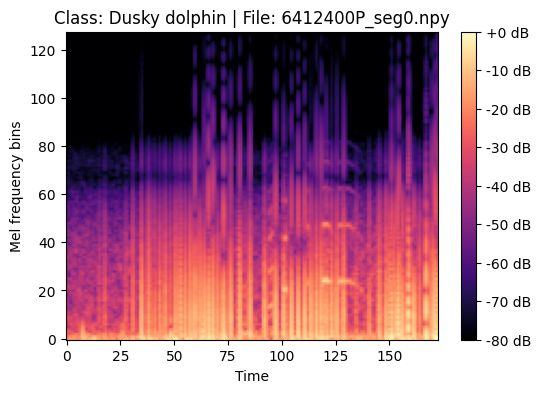

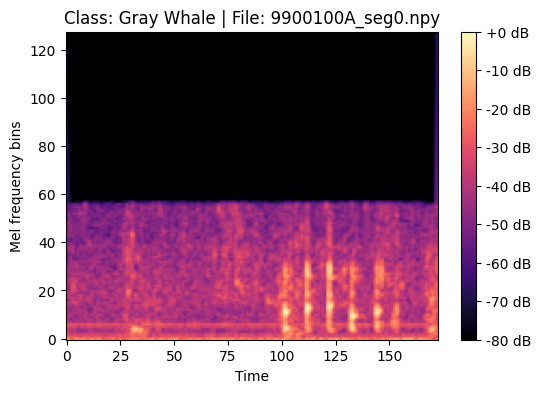

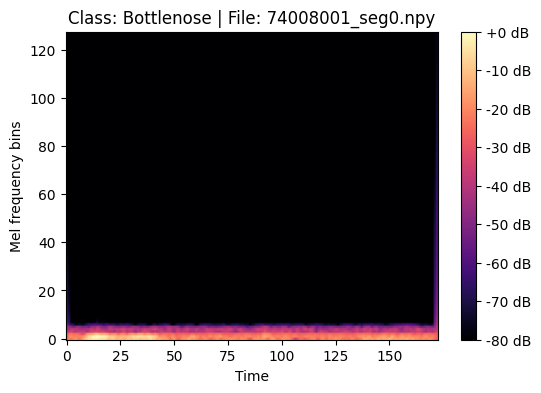

In [6]:
#Visualise
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to your spectrogram folder
spectrogram_folder = '/content/drive/MyDrive/Spectrograms'

# Get class folders
class_folders = [os.path.join(spectrogram_folder, d) for d in os.listdir(spectrogram_folder) if os.path.isdir(os.path.join(spectrogram_folder, d))]

# Pick one file from each class to visualize
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    files = [f for f in os.listdir(class_folder) if f.endswith('.npy')]
    if not files:
        continue

    file_path = os.path.join(class_folder, files[0])
    mel = np.load(file_path)

    plt.figure(figsize=(6,4))
    plt.title(f"Class: {class_name} | File: {files[0]}")
    plt.imshow(mel, aspect='auto', origin='lower', cmap='magma')
    plt.xlabel('Time')
    plt.ylabel('Mel frequency bins')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [7]:
#Checking spectograms to ensure consistency ,load them into NumPy arrays grouped by Class

base = '/content/drive/MyDrive/Spectogram'

X, y = [], [] #y for the labels
labels = sorted(os.listdir(base)) #check for ordering

for label_index, class_name in enumerate(labels):
  class_folder = os.path.join(base, class_name)
  if not os.path.isdir(class_folder):
    continue

  for file in os.listdir(class_folder):
    if file.endswith('.npy'):
      path = os.path.join(class_folder, file)
      data = np.load(path)

      data = ( data - np.min(data)) / (np.max(data) - np.min(data))

      data = np.expand_dims(data, axis = -1)

      X.append(data)
      y.append(label_index)

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} spectograms")

Loaded 264 spectograms


In [8]:
#Splitting data

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size =0.3, stratify = y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_Test, y_Test, test_size=0.5, stratify=y_Test, random_state=42)

In [9]:
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 184
Validation samples: 40
Testing samples: 40


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]  # (freq_bins, time_frames, 1)
num_classes = len(labels)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



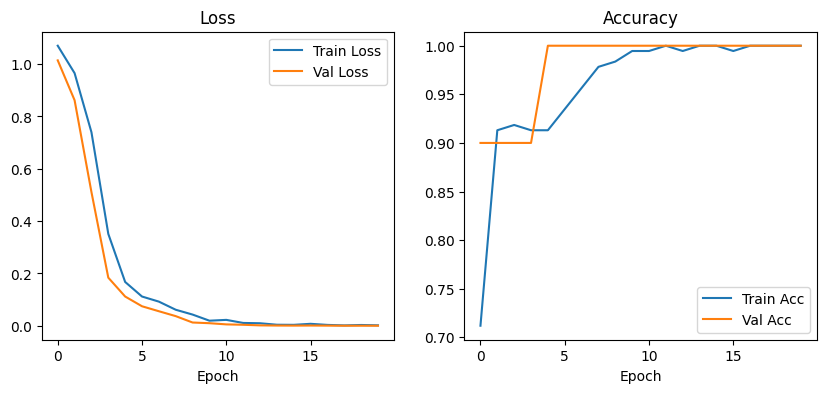

Epoch 20/20 completed.


In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Number of epochs
epochs = 20

# Storage for metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # Train for one epoch
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=32,
        verbose=0
    )

    # Save metrics
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    train_accs.append(history.history['accuracy'][0])
    val_accs.append(history.history['val_accuracy'][0])

    # Clear previous output and plot new curves
    clear_output(wait=True)
    plt.figure(figsize=(10,4))

    # --- Loss ---
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

    print(f"Epoch {epoch+1}/{epochs} completed.")


In [15]:
#Collecting metrices for web based visualisation
import pickle

# After model.fit(...)
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

from google.colab import files
files.download('history.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate report
print(classification_report(y_test, y_pred, target_names=labels))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
               precision    recall  f1-score   support

   Bottlenose       1.00      1.00      1.00        33
Dusky dolphin       1.00      1.00      1.00         4
   Gray Whale       1.00      1.00      1.00         3

     accuracy                           1.00        40
    macro avg       1.00      1.00      1.00        40
 weighted avg       1.00      1.00      1.00        40

